## Leauge of Legends Champion Complexity EDA
##### By: Ryan Stevens
##### For: DSCI 235


Full project can be found here: https://github.com/keinnyne000/LoL-Complexity-EDA/

##### Motivation:

Online competitive multiplayer video games are an increasingly popular passtime for America. According to ------. However, as the medium grows, the more successful titles need to search for methods to keep users engaged. [transition] The problem lies in the tradeoff between appealing to new users by prioritizing simplicity and maintaining a dedicated playerbase of long-time users with progressively more and more complex systems.

League of Legends, one of the most popular examples of such a game faces this issue. The company in charge of the product--Riot Games--frequently receives backlash from users on both sides of the debate, either complaining the game is too complex or not complex enough. 

By understanding which champions are complex, why they are complex, and how that complexity relates to long-term champion monetary performance, champion designers can make more informed choices.

##### Questions:
1. How can champion complexity be quantified?
2. How does champion complexity relate to champion playrate?
3. Does champion complexity vary by rank?

Important note! The data used in this project is VERY BIG. Hence, it is not possible to upload the data directly to GitHub.

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

The nature of this project is grounded in creating a theory for measuring champion complexity. As such, it is very exploratory in nature.

My first theory was simply to relate the number of actions that a given character makes per minute in a game to the complexity of said character. IE: If a character takes 5,000 actions per minute (that's a lot) and another takes only 5, then the first character is clearly more complex.

So, I collected 10,000 ranked 5v5 matches from the Riot Games developer API using a python script (we'll talk about this later). I chose matches from the "Diamond II" skill bracket (~99th percentile) for two main reasons:
1. Sufficiently skilled players are required to play the champions "correctly"
2. This is the lowest tier included in Riot Games' self-defined "Elite" tier

Let's load the data:

In [107]:
d2_data = pd.read_json('database/data_d2_1000_10.json')

We'll validate the data is in the format we want

In [108]:
d2_data.head(2)

,metadata,info
0,"{'dataVersion': '2', 'matchId': 'NA1_525689035...","{'endOfGameResult': 'GameComplete', 'gameCreat..."
1,"{'dataVersion': '2', 'matchId': 'NA1_525686558...","{'endOfGameResult': 'GameComplete', 'gameCreat..."


We only want the "info" column as we don't care about the exact game version or match ID. Let's get that:

In [109]:
cleaned_d2 = pd.DataFrame(d2_data['info'].to_list())

The following code can be used to speed up the programming process, it's commented out for the final version, however!

In [110]:
#cleaned_d2 = cleaned_d2.sample(1000)

Each match data has 10 participants so we'll extract those and then discard everything else.

In [111]:
cleaned_d2 = [c for p in cleaned_d2['participants'] for c in p[:10]]
cleaned_d2 = pd.DataFrame(cleaned_d2)

The Riot API uses a number of DTOs (Data Transfer Objects), which come in the form of dictionaries nested in the match data. In order to process our data further, we will need to flatten these.

In [112]:
cleaned_d2 = cleaned_d2.apply(lambda row: row.map(lambda x: str(x) if isinstance(x, dict) else x), axis=1)
cleaned_d2 = cleaned_d2.drop_duplicates()

Let's look at the relationship between spell casts and champions:

In [113]:
grouped_d2 = cleaned_d2.groupby('championName')
casts_d2 = grouped_d2[['spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts']].mean().sum(axis=1).sort_values(ascending=False)

Let's visualize the top 10 highest action characters:

*notably, we have just taken the mean of the sum of all spell casts, this doesn't actually take game length in to account just yet, so some characters, who end up in longer games on average will have inflated actions*

<Axes: xlabel='championName'>

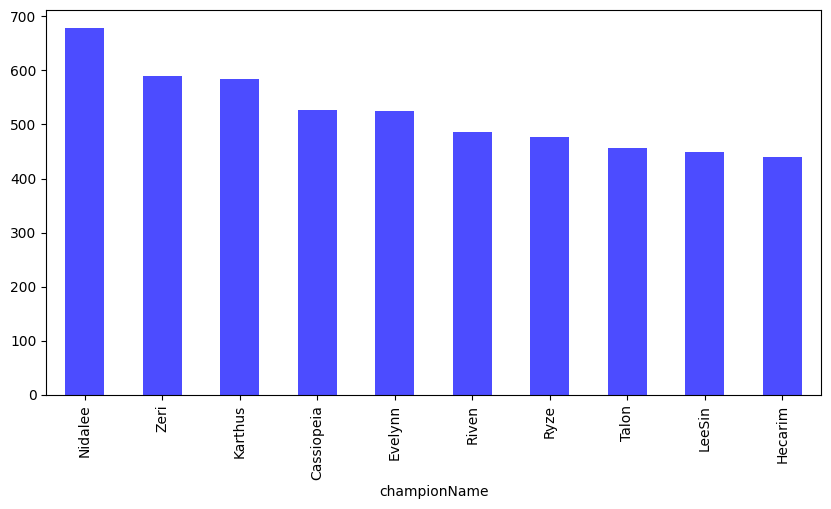

In [114]:
casts_d2 = casts_d2.sort_values(ascending=False)
casts_d2[:10].plot(kind='bar', figsize=(10, 5), color='blue', alpha=0.7)

Let's do the bottom 10 while we're at it:

<Axes: xlabel='championName'>

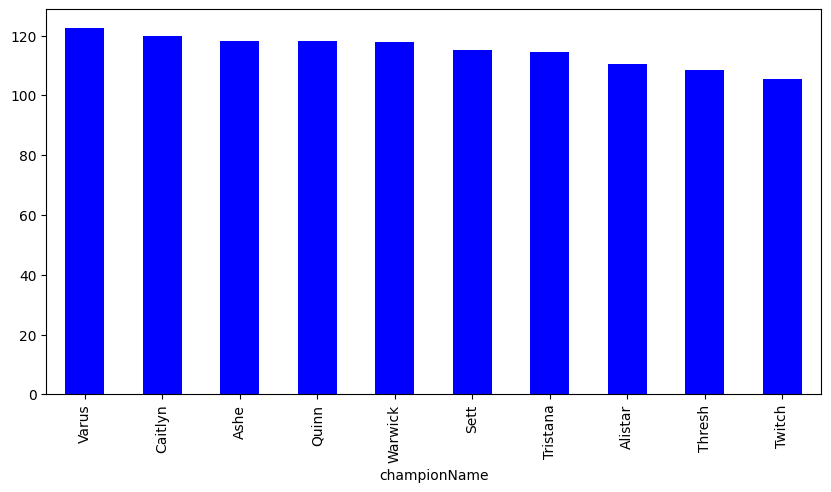

In [115]:
casts_d2[-10:].plot(kind='bar', figsize=(10, 5), color='blue')

These plots are very eye-opening.

Initially, especially for the plot depicting the top 10 champions, the results look promising. Nidalee, the character that ranks highest, is indeed a very complex and difficult character that even many professional-level players cannot operate properly. Furthermore, Zeri, Cassiopeia, Riven, and Lee Sin are also contenders for the most complex and difficult characters in the game. 

However, some cracks show, especially for the "bottom 10" group, which features characters such as Caitlyn, Ashe, and Twitch, which are all champions from the same class, who are being underrepresented because the data that the Riot Games API stores doeas not include the statistics that cover the majority of their complexity. In general, there are a number of oddities in the data that seem to suggest that this method is--at the very least-- incomplete.

So, I collected data from a different skill bracket to measure the difference between them. The intuition being that by measuring this difference, we can factor out any biases.

Let's load the data and run the same processing on it:

In [137]:
data_g4 = pd.read_json('database/data_g4_1000_10.json')
cleaned_g4 = pd.DataFrame(data_g4['info'].to_list())
# cleaned_g4 = cleaned_g4.sample(1000) #<- Commented out for final version
cleaned_g4 = [c for p in cleaned_g4['participants'] for c in p[:10]]
cleaned_g4 = pd.DataFrame(cleaned_g4)
cleaned_g4 = cleaned_g4.apply(lambda row: row.map(lambda x: str(x) if isinstance(x, dict) else x), axis=1)
cleaned_g4 = cleaned_g4.drop_duplicates()

Gold 4 was chosen as it is typically seen as an "average" level of play

In [140]:
grouped_g4 = cleaned_g4.groupby('championName')
casts_g4 = grouped_g4[['spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts']].mean().sum(axis=1).sort_values(ascending=False)

We'll compare the differences:

In [141]:
diff = casts_d2 - casts_g4
diff.sort_values(ascending=False, inplace=True)

<Axes: xlabel='championName'>

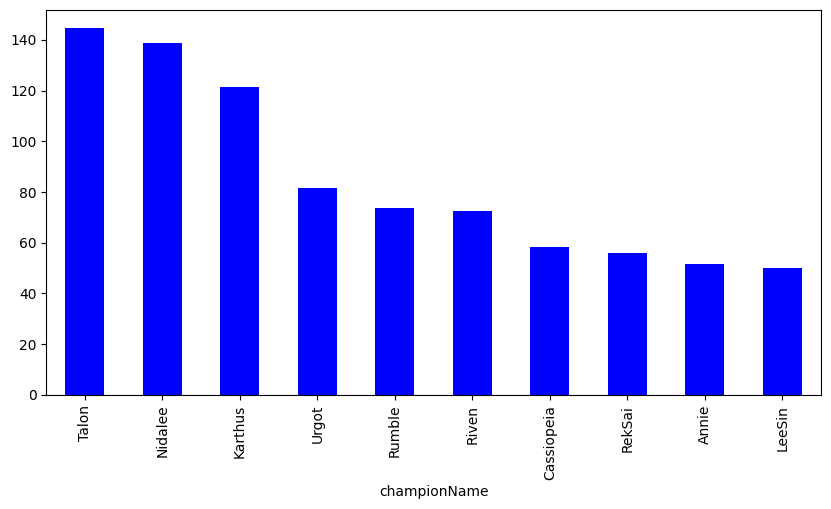

In [142]:
diff[:10].plot(kind='bar', figsize=(10, 5), color='blue')

High action characters are still dominating the plot (Karthus is a good litmus test for this)--let's normalize it:

<Axes: xlabel='championName'>

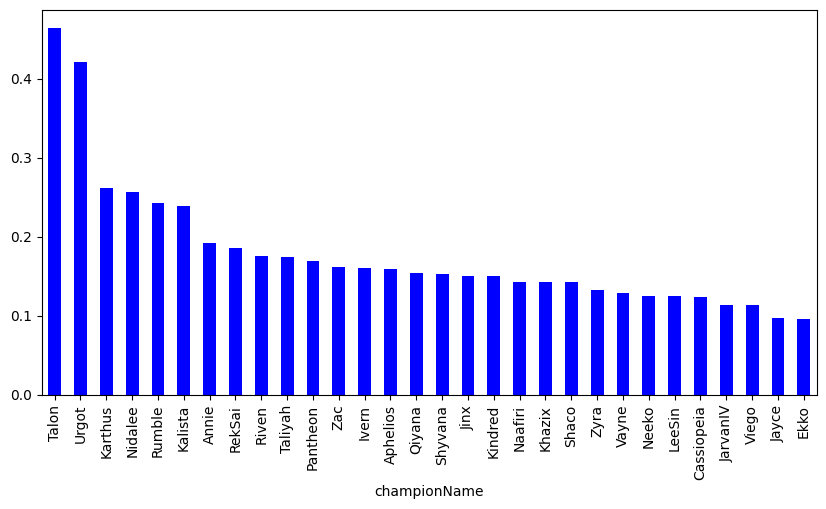

In [148]:
proportional_diff = diff / casts_g4
proportional_diff.sort_values(ascending=False, inplace=True)
proportional_diff[:30].plot(kind='bar', figsize=(10, 5), color='blue')

<Axes: xlabel='championName'>

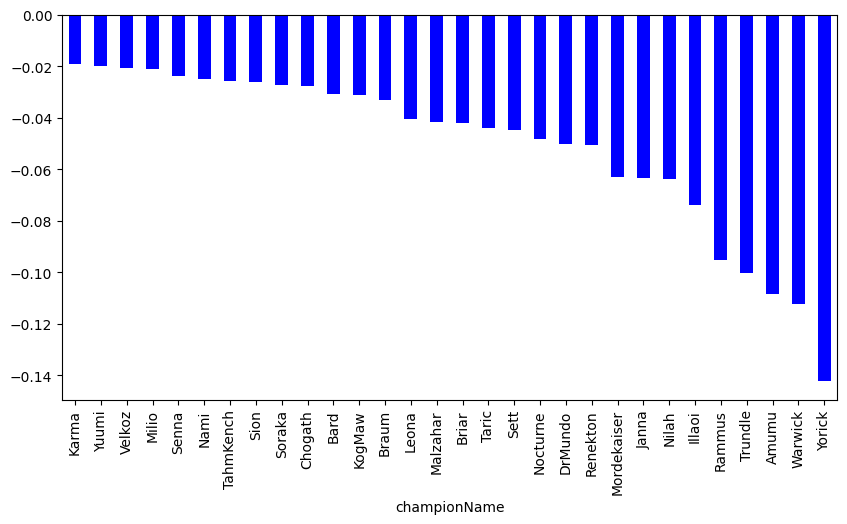

In [147]:
proportional_diff[-30:].plot(kind='bar', figsize=(10, 5), color='blue')

<Axes: xlabel='championName'>

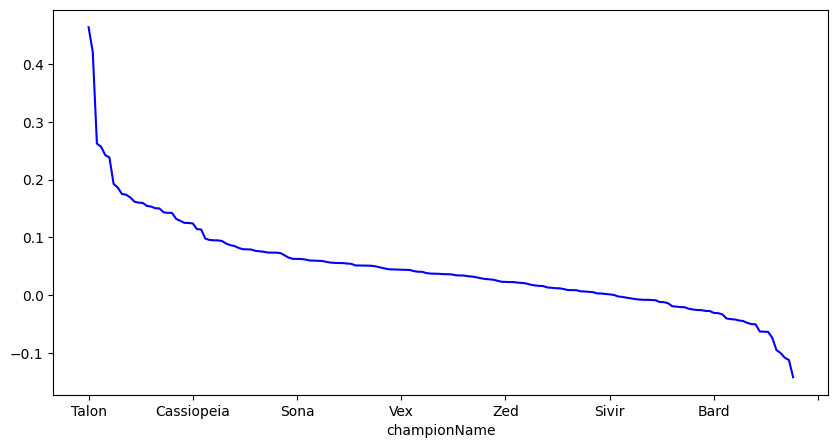

In [145]:
proportional_diff.plot(kind='line', figsize=(10, 5), color='blue')

These results--especially for the negative characters--seem pretty promising. There are certainly some outliers, however. Notably a character like "Bard" probably shouldn't be in the bottom 30 and a character like "Rek'Sai" or "Annie" probably shouldn't be in the top 10. 

My hypothesis is that this is because we are still introducing bias by virtue of focusing on spellcasts. This underrepresents characters that have more strategic complexity like Bard and overrepresents characters that use a lot of simple but frequent spellcasts like Annie.

As such, we should extend the analysis to include a wider set of data. 

The new method will be to examine which characters have a major change in any of their statistics with rank. We'll remove non-numeric columns and then take the normalized euclidean distance between gold 4 and diamond 2 player's statistics grouped by champion. 

In [155]:
cleaned_d2.shape # 145 columns

(91370, 145)

In [156]:
grouped_d2_full = cleaned_d2.groupby('championName').mean(numeric_only=True).reset_index()
grouped_g4_full = cleaned_g4.groupby('championName').mean(numeric_only=True).reset_index()

We set the index to be 'championName' since it makes subtracting the remaining numeric columns easier and doesn't lose us any data.

In [157]:
grouped_d2_full.set_index('championName', inplace=True)
grouped_g4_full.set_index('championName', inplace=True)

In [158]:
grouped_d2_full.shape # 132 columns

(170, 132)

Let's be careful when calculating our difference as some values are 0!

In [159]:
grouped_g4_full.max().sort_values(ascending=True).head(5)

PlayerScore11    0.0
PlayerScore10    0.0
PlayerScore9     0.0
basicPings       0.0
dangerPings      0.0
dtype: float64

In [160]:
numerator = grouped_d2_full - grouped_g4_full
denominator = (grouped_d2_full + grouped_g4_full) / 2
diff_full = numerator.divide(denominator.replace(0, np.nan))

In [161]:
diff_full = diff_full.dropna(axis=1, how='all')

In [162]:
diff_full['sqMagnitude'] = diff_full.pow(2).sum(axis=1)

In [163]:
diff_full.sort_values(by='sqMagnitude', ascending=False, inplace=True)

Let's see:

<Axes: xlabel='championName'>

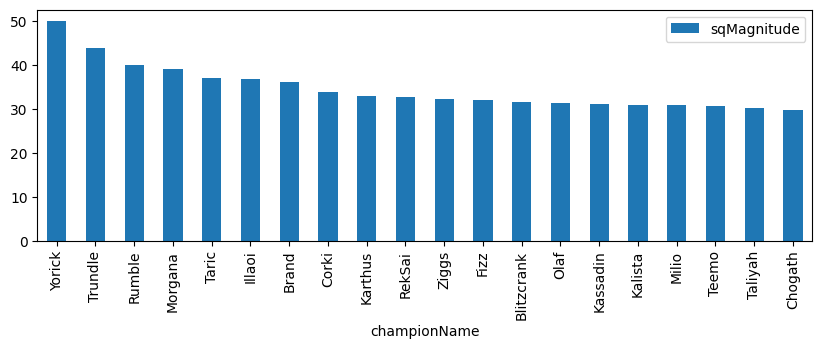

In [217]:
diff_full[:20].plot(kind='bar', figsize=(10, 3), y='sqMagnitude')

<Axes: xlabel='championName'>

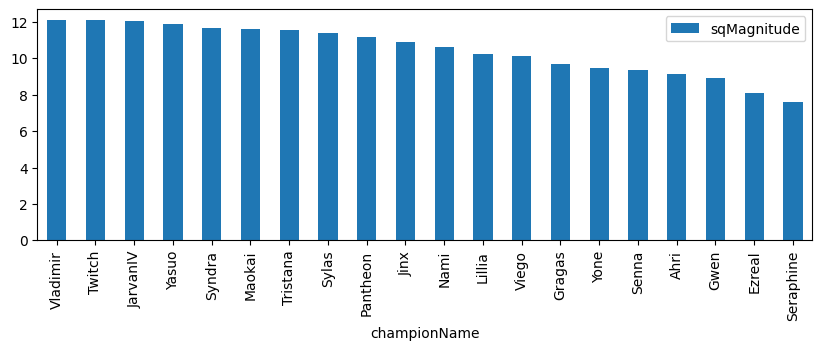

In [216]:
diff_full[-20:].plot(kind='bar', figsize=(10, 3), y='sqMagnitude')

Yikes. So these results are not what I was hoping for. Interestingly, it seems that the characters that rank highly here are ones that are typically less prevalant in higher ranks due to issues with their designs. 

Otherwise, results seem very random.

<Axes: xlabel='championName'>

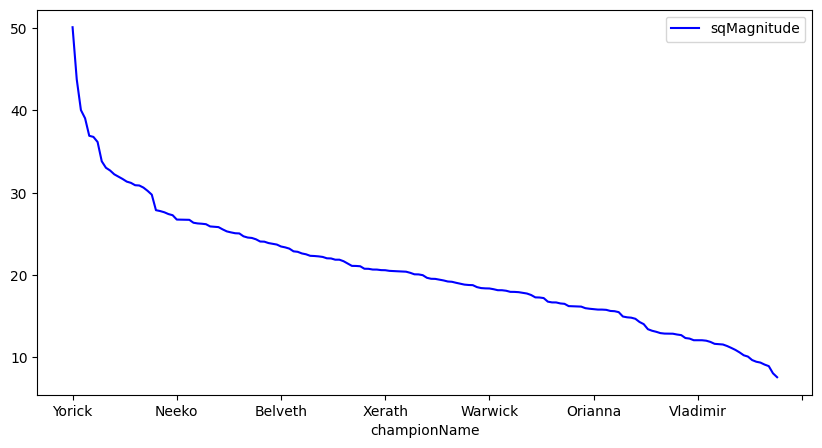

In [167]:
diff_full.plot(kind='line', figsize=(10, 5), color='blue', y='sqMagnitude')

Next, let's try to answer research questions #2 and #3.

In [174]:
d2_occurances = cleaned_d2['championName'].value_counts()
g4_occurances = cleaned_g4['championName'].value_counts()

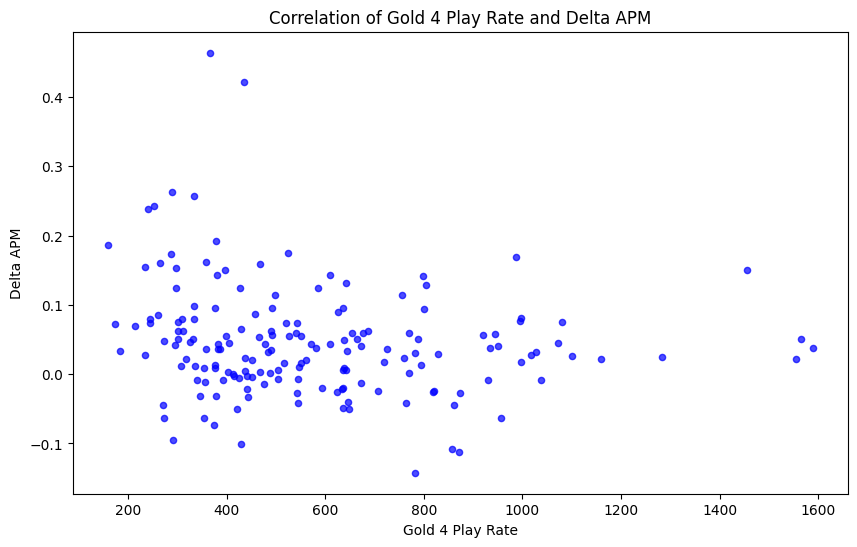

In [225]:
correlation_data = pd.DataFrame({'occurances': g4_occurances, 'proportional_diff': proportional_diff})
correlation_data.plot(kind='scatter', x='occurances', y='proportional_diff', figsize=(10, 6), color='blue', alpha=0.7)
plt.title('Correlation of Gold 4 Play Rate and Delta APM')
plt.xlabel('Gold 4 Play Rate')
plt.ylabel('Delta APM')
plt.show()

The correlation seems pretty weak. There might be a slight 'narrowing' of the delta APM as the play rate increases. It appears this indicates a potential slight preference for characters with slightly above average APM deltas. Or in other words, people seem to like playing characters that are a little complex but not too much more complex.

However, again, this is not a particularly strong correlation.

Let's move on to the difference between Diamond 2 and Gold 4 playrates. This seeks to answer question #3, which asks how much more/less are complex champions played in different ranks based on skill?

Let's start out by looking at which characters are more likely to be played simply because of the rank:

<Axes: xlabel='championName'>

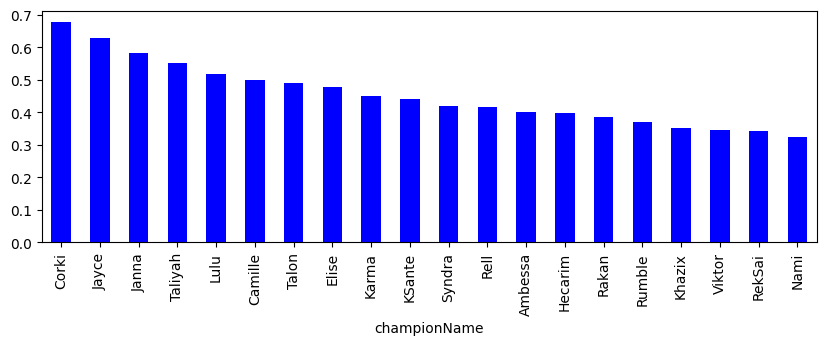

In [211]:
diff_occurances = d2_occurances - g4_occurances
diff_occurances = diff_occurances / (g4_occurances + d2_occurances) * 2
diff_occurances.sort_values(ascending=False, inplace=True)
diff_occurances[:20].plot(kind='bar', figsize=(10, 3), color='blue')

<Axes: xlabel='championName'>

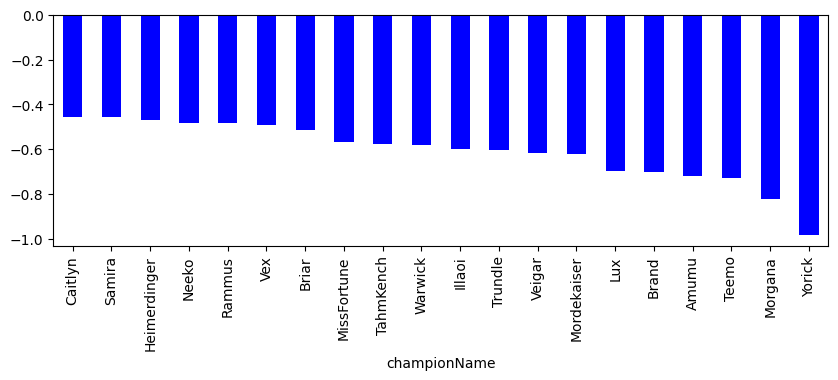

In [210]:
diff_occurances[-20:].plot(kind='bar', figsize=(10, 3), color='blue')


Above are some graphs detailing the delta playrates in champions between Diamond 2 and Gold 4. Corki is played more in Diamond 2, wheras Yorick is played much less. This is roughly what we would expect to see!

Let's see how this correlates with our complexity metric!

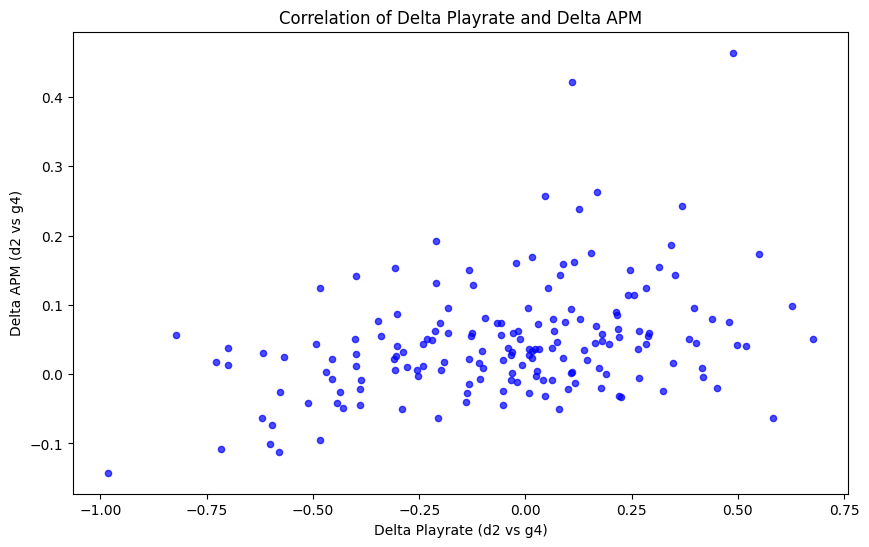

In [226]:
correlation_data = pd.DataFrame({'diff_occurances': diff_occurances, 'proportional_diff': proportional_diff})
correlation_data.plot(kind='scatter', x='diff_occurances', y='proportional_diff', figsize=(10, 6), color='blue', alpha=0.7)
plt.title('Correlation of Delta Playrate and Delta APM')
plt.xlabel('Delta Playrate (d2 vs g4)')
plt.ylabel('Delta APM (d2 vs g4)')
plt.show()

Right off the bat, we can see that, if there is a correlation, it's pretty weak. There seems to be a slightly positive trend as well as some significant outliers but otherwise nothing particularly promising.

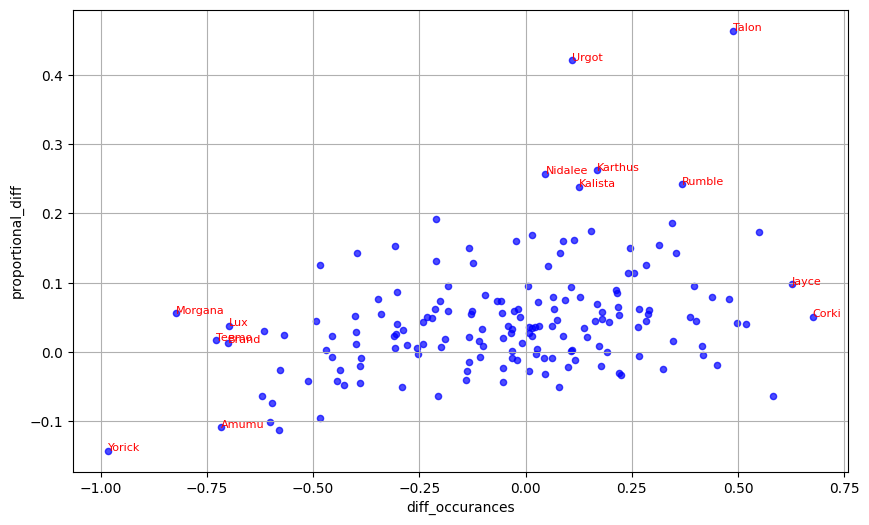

In [213]:
#################################################################################################
# FULL DISCLOSURE: ALL OF THE CODE IN THIS BLOCK WAS GENERATED BY CLAUDE 3.7 SONNET             #
# I HAVE INCLUDED IT HERE BECAUSE I THOUGHT IT WAS INTERESTING, PLEASE IGNORE IF YOU WOULD LIKE #
# IT WAS NOT USED IN ANY WAY IN THE FINAL ANALYSIS FOR THE PROJECT                              #
#################################################################################################

from scipy.stats import zscore

# Add z-score columns
correlation_data['zscore_x'] = zscore(correlation_data['diff_occurances'])
correlation_data['zscore_y'] = zscore(correlation_data['proportional_diff'])

# Define outliers (change threshold as needed)
outliers = correlation_data[(correlation_data['zscore_x'].abs() > 2) | 
                            (correlation_data['zscore_y'].abs() > 2)]

# Plot
ax = correlation_data.plot(kind='scatter', x='diff_occurances', y='proportional_diff', figsize=(10, 6), color='blue', alpha=0.7)
plt.xlabel('diff_occurances')
plt.ylabel('proportional_diff')
plt.grid(True)

# Annotate outliers
for i, row in outliers.iterrows():
    ax.text(row['diff_occurances'], row['proportional_diff'], str(i), fontsize=8, color='red')

plt.show()

Let's fit a simple linear regression to see how well our model represents the data.

R^2 score: 0.13401278643890135


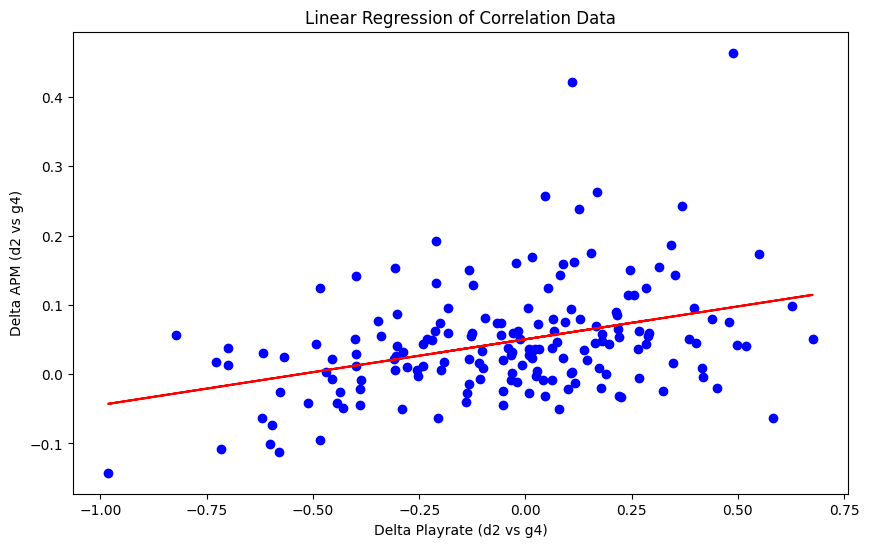

In [227]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = correlation_data['diff_occurances'].values.reshape(-1, 1)
y = correlation_data['proportional_diff'].values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
print(f"R^2 score: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue')
plt.plot(X, y_pred, color='red')
plt.title('Linear Regression of Correlation Data')
plt.xlabel('Delta Playrate (d2 vs g4)')
plt.ylabel('Delta APM (d2 vs g4)')
plt.show()

It looks like our R^2 score is roughly 13%. This indicates that while there is indeed some variance explained by the delta APM in our playrate, the fit is ultimately quite weak.

We could say that 13% of the variance in the playrate can be explained by how many actions it takes to play a given character.

Interesting.

## Conclusion

Initially, we set out to answer the following questions:

1. How can champion complexity be quantified?
2. How does champion complexity relate to champion playrate?
3. Does champion complexity vary by rank?

As we explored the data, we came across some answers as well as some futher questions. It seems like champion complexity (ironically) is quite complex. Given the relatively sparse data provided by the Riot API, it is quite difficult to find a single metric that works.

<Axes: xlabel='championName'>

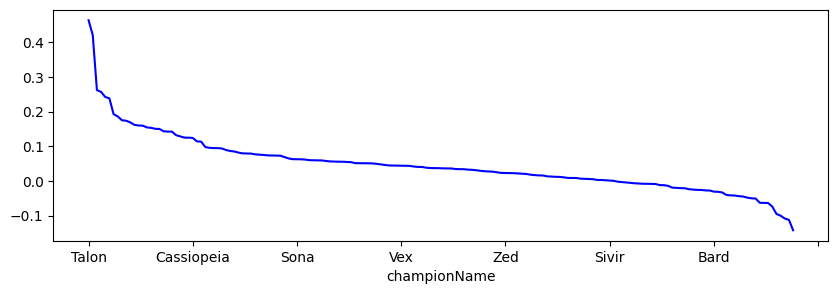

In [198]:
proportional_diff.plot(kind='line', figsize=(10, 3), color='blue')

The best model we found was to compare the proportional difference in ability casts between ranks. This led us to a model that--not perfect--still seemed to predict character complexity with some accuracy.

This answers our first question:
Q: How can champion complexity be quantified? 
A: By the number of spellcasts, though it's a complicated question and would do well to take more dense data in to account.

Next, we found that, using the "Delta APM" metric as our quantification for complexity, that champion playrate did indeed seem to vary based on complexity:

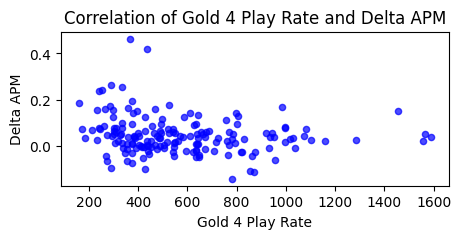

In [229]:
correlation_data = pd.DataFrame({'occurances': g4_occurances, 'proportional_diff': proportional_diff})
correlation_data.plot(kind='scatter', x='occurances', y='proportional_diff', figsize=(5, 2), color='blue', alpha=0.7)
plt.title('Correlation of Gold 4 Play Rate and Delta APM')
plt.xlabel('Gold 4 Play Rate')
plt.ylabel('Delta APM')
plt.show()

This answers our second question:
Q: How does champion complexity relate to champion playrate?
A: It seems like champion complexity has a sweet spot where characters that are slightly complex but not aggressively so are the most popular.

Finally, we looked at the correlation between the delta in APM between ranks and the delta in playrate. We found a R^2 score that answered our final question:
Q: Does champion complexity vary by rank?
A: ~13% of the change in playrate for characters between ranks can be attributed to champion complexity.

#### Future Work & Closing Notes:
As mentioned, I think that future work should look at more detialed data--perhaps using the Riot API to get "timeline" data for matches, which details important events throughout a game, or even find a way to collect data directly from the .replay files that have *all* of the actions performed in a game. This would probably make sense alongside a more powerful model. 

Alternatively, more precise metrics could be created by hand, perhaps taking some statistics in to account at a higher weight than others. For example, 50% of the metric could use the proportional APM and the remainder be determined by the other 131 numeric metrics.

Either way, this an interesting project that I intend to return to in some capacity in the future!

## Resources

#### API Data Collector

The following is the API data collector that was used to get data from the Riot API. I wrote the entire thing by hand using concepts from DSCI235, hence its inclusion here. The collector deals with a bit of the complexity caused from the API and makes sure we get the data we want!

In [ ]:
import numpy as np
import pandas as pd
import asyncio
import aiohttp
from tqdm.asyncio import tqdm_asyncio
import time
import random
from asyncio import Lock
import sys

from helpers import write_json_list, parse_match_data

ACCESS_POINT = "https://americas.api.riotgames.com"
API_KEY = "" # I understand this is not best practice... but it works!

RATE_LIMIT = 100
WINDOW = 120  # seconds
REQUEST_INTERVAL = WINDOW / RATE_LIMIT  # 1.2s (for 100 requests per 2 minutes)
MAX_CONCURRENT_REQUESTS = 5

# A Semaphore is like a bathroom pass. It's what allows us to limit the number of concurrent requests.
# This helps us avoid hitting the rate limit.
concurrency_semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)
last_request_time = 0
request_lock = Lock()

#----------------------------------------------------------------------------------------------------

# I didn't get around to using this function as the parsing was better suited to the above notebook
def parse_match_data(match_data):
    return match_data

def write_json(json, filename):
    with open(filename, 'w') as f:
        f.write(json)

#---------------------------------------------------------------------------------------------

async def rate_limited_wait():
    global last_request_time
    async with request_lock:
        now = time.monotonic()
        wait_time = last_request_time + REQUEST_INTERVAL - now
        if wait_time > 0:
            await asyncio.sleep(wait_time)
        last_request_time = time.monotonic()

async def limited_get(session, url, max_retries=5):
    async with concurrency_semaphore:
        await rate_limited_wait()
        for attempt in range(max_retries):
            try:
                async with session.get(url) as response:
                    if response.status == 429:
                        retry_after = int(response.headers.get("Retry-After", 1))
                        print(f"Rate limited, retrying after {retry_after} seconds")
                        await asyncio.sleep(retry_after + random.uniform(0.1, 0.5))
                        continue
                    response.raise_for_status()
                    return await response.json()
            except aiohttp.ClientResponseError as e:
                if e.status == 429:
                    await asyncio.sleep(2 ** attempt + random.uniform(0.1, 0.5))
                    continue
                raise
        raise Exception(f"Failed after {max_retries} retries: {url}")

#----------------------------------------------------------------------------------------------------
    
async def async_get_league_page(session, tier, division, page, api_key):
    # tier: IRON, BRONZE, SILVER, GOLD, PLATINUM, DIAMOND, MASTER, GRANDMASTER, CHALLENGER
    # division: I, II, III, IV
    na1_access_point = 'https://na1.api.riotgames.com'
    if(tier == 'MASTER' or tier == 'GRANDMASTER' or tier == 'CHALLENGER'):
        url = f"{na1_access_point}/lol/league/v4/{tier.lower()}leagues/by-queue/RANKED_SOLO_5x5?api_key={api_key}"
        response = await limited_get(session, url)
        return response['entries']
    else:
        url = f"{na1_access_point}/lol/league/v4/entries/RANKED_SOLO_5x5/{tier}/{division}?page={page}&api_key={api_key}"
        return await limited_get(session, url)

async def async_get_matches(session, puuid, api_key, count = 100):
    url = f"{ACCESS_POINT}/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count={count}&api_key={api_key}"
    return await limited_get(session, url)

async def async_get_match_data(session, match_id, api_key):
    url = f"{ACCESS_POINT}/lol/match/v5/matches/{match_id}?api_key={api_key}"
    return await limited_get(session, url)

async def async_get_timeline_data(session, match_id, api_key):
    url = f"{ACCESS_POINT}/lol/match/v5/matches/{match_id}/timeline?api_key={api_key}"
    return await limited_get(session, url)

#----------------------------------------------------------------------------------------------------

# Gets match datas for a player with a given depth
async def get_player_match_data(session, player_id, api_key, depth):
    puuid_short = player_id['puuid'][:8]
    print(f"[DEBUG] Handling player {puuid_short}...")
    try:
        print(f"[INFO] Fetching match IDs for player {puuid_short}")
        match_ids = await async_get_matches(session, player_id['puuid'], api_key, count=depth)
        print(f"[INFO] Retrieved {len(match_ids)} matches for {puuid_short}")
        print(f"[INFO] Fetching match data for {puuid_short}...")
        tasks = [async_get_match_data(session, match_id, api_key) for match_id in match_ids]
        results = await asyncio.gather(*tasks)
        print(f"[INFO] Parsing match data for {puuid_short}")
        return [parse_match_data(match) for match in results]
    except Exception as e:
        print(f"[ERROR] Failed to process player {puuid_short}: {e}")
        return []

# Gets timeline data for a player with a given depth
async def get_player_timeline_data(session, player_data, api_key, depth):
    puuid_short = player_data['puuid'][:8]
    print(f"[DEBUG] Getting timeline data for {puuid_short}...")
    try:
        print(f"[INFO] Fetching match IDs for player {puuid_short}")
        match_ids = await async_get_matches(session, player_data['puuid'], api_key, count=depth)
        print(f"[INFO] Retrieved {len(match_ids)} matches for {puuid_short}")
        print(f"[INFO] Fetching timeline data for {puuid_short}...")
        tasks = [async_get_timeline_data(session, match_id, api_key) for match_id in match_ids]
        results = await asyncio.gather(*tasks)
        print(f"[INFO] Parsing timeline data for {puuid_short}")
        return [parse_match_data(timeline) for timeline in results]
    except Exception as e:
        print(f"[ERROR] Failed to process player {puuid_short}: {e}")
        return []


#----------------------------------------------------------------------------------------------------

def process_data(results, start_time):
        match_data = []
        for result in results:
            match_data.extend(result)

        total_time = time.time() - start_time
        print(f"[INFO] Finished processing all data in {total_time:.2f} seconds. Total matches: {len(match_data)}")
        
        return match_data

#-------------------------------------------------------------------------------------

# returns a list of player ids on the given tier and division
async def get_players_by_division(session, tier, division, player_count, api_key):
    results = []
    page_number = 1
    print(f"[INFO] Sampling {player_count} players from {tier} {division}...")
    while(len(results) < player_count):
        print(f"[INFO] Fetching league page data no.{len(results)} for {tier} {division}...")
        page_data = await async_get_league_page(session, tier, division, page_number, api_key)
        results.extend(page_data)
        page_number += 1
    return results[:player_count]

async def get_players_from_all_divisions(session, player_count, api_key):
    results = []
    for tier in ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND']:
        for division in ['I', 'II', 'III', 'IV']:
            players = await get_players_by_division(session, tier, division, player_count, api_key)
            results.extend(players)
    for tier in ['MASTER', 'GRANDMASTER', 'CHALLENGER']:
        players = await get_players_by_division(session, tier, 'I', player_count, api_key)
        results.extend(players)
    return results

# returns a list of player ids based on the sampled distribution
async def get_players_distribution(session, distribution, player_count, api_key):
    players = []
    for d in distribution.iloc():
        count = int(np.ceil(d['percentage'] * player_count))
        players.extend(await get_players_by_division(session, d['tier'], d['division'], count, api_key))
    return players

#----------------------------------------------------------------------------------------

# returns a list of match data for the given players
async def get_match_data_from_players(session, players, api_key, depth):
    tasks = [get_player_match_data(session, player, api_key, depth) for player in players]
    results = await tqdm_asyncio.gather(*tasks, desc="Processing Players")
    return results

async def get_timeline_data_from_players(session, players, api_key, depth):
    tasks = [get_player_timeline_data(session, player, api_key, depth) for player in players]
    results = await tqdm_asyncio.gather(*tasks, desc="Processing Players")
    return results

#----------------------------------------------------------------------------------------------------


async def get_timelines_from_all_divisions(session, player_count, depth, api_key):
    print(f"[INFO] Starting async_get_timeline_data | Player Count: {player_count}, Depth: {depth}")
    start_time = time.time()
    players = await get_players_from_all_divisions(session, player_count, api_key)
    results = await get_timeline_data_from_players(session, players, api_key, depth)
    return process_data(results, start_time)

async def get_timelines_from_division(session, tier, division, player_count, depth, api_key):
    print(f"[INFO] Starting async_get_timeline_data | Tier: {tier}, Division: {division}, Player count: {player_count}, Depth: {depth}")
    start_time = time.time()
    players = await get_players_by_division(session, tier, division, player_count, api_key)
    results = await get_timeline_data_from_players(session, players, api_key, depth)
    return process_data(results, start_time)

async def get_timelines_from_distribution(session, player_count, depth, distribution, api_key):
    print(f"[INFO] Starting async_get_timeline_data | Player Count: {player_count}, Depth: {depth}")
    start_time = time.time()
    players = await get_players_distribution(session, distribution, player_count, api_key)
    results = await get_timeline_data_from_players(session, players, api_key, depth)
    return process_data(results, start_time)

async def get_matches_from_all_divisions(session, player_count, depth, api_key):
    print(f"[INFO] Starting async_get_league_data | Player Count: {player_count}, Depth: {depth}")
    start_time = time.time()
    players = await get_players_from_all_divisions(session, player_count, api_key)
    results = await get_match_data_from_players(session, players, api_key, depth)
    return process_data(results, start_time)

# returns a list of match data for the given division
async def get_matches_from_division(session, tier, division, player_count, depth, api_key):
    print(f"[INFO] Starting async_get_league_data | Tier: {tier}, Division: {division}, Player count: {player_count}, Depth: {depth}")
    start_time = time.time()
    players = await get_players_by_division(session, tier, division, player_count, api_key)
    results = await get_match_data_from_players(session, players, api_key, depth)
    return process_data(results, start_time)

async def get_matches_from_distribution(session, player_count: int, depth: int, distribution, api_key):
    print(f"[INFO] Starting async_sample_distribution | Player Count: {player_count}, Depth: {depth}")
    start_time = time.time()
    players = await get_players_distribution(session, distribution, player_count, api_key)
    results = await get_match_data_from_players(session, players, api_key, depth)
    return process_data(results, start_time)

#-----------------------------------------------------------------------------------------------------

def parse_common_args(args):
    if len(args) < 3:
        raise ValueError(f"Expected at least {3} arguments, got {len(args)}")
    file_path = args[0]
    try:
        count = int(args[1])
        depth = int(args[2])
    except ValueError:
        raise ValueError("count and depth must be integers")
    print(f"[INFO] File path: {file_path}, Count: {count}, Depth: {depth}")
    return file_path, count, depth

async def main(args):
    flag = args[-1]
    print(f"ARGS: {args[4:6]}")
    print(f"flag: {flag}")

    if flag == '-ta':
        print("[INFO] Fetching timeline data for all divisions...")
        file_path, count, depth = parse_common_args(args[1:])
        async with aiohttp.ClientSession() as session:
            result = await get_timelines_from_all_divisions(session, count, depth, API_KEY)
            write_json_list(result, file_path)
    elif flag == '-tv':
        print("[INFO] Fetching timeline data for a specific division...")
        file_path, count, depth = parse_common_args(args[1:])
        tier, division = args[4:6]
        async with aiohttp.ClientSession() as session:
            result = await get_timelines_from_division(session, tier, division, count, depth, API_KEY)
            write_json_list(result, file_path)
    elif flag == '-ts':
        print("[INFO] Fetching timeline data by distribution...")
        file_path, count, depth = parse_common_args(args[1:])
        distribution = pd.read_json('rank_distribution_32825.json')
        async with aiohttp.ClientSession() as session:
            result = await get_timelines_from_distribution(session, count, depth, distribution, API_KEY)
            write_json_list(result, file_path)
    elif flag == '-ma':
        print("[INFO] Fetching match data for all divisions...")
        file_path, count, depth = parse_common_args(args[1:])
        async with aiohttp.ClientSession() as session:
            result = await get_matches_from_all_divisions(session, count, depth, API_KEY)
            write_json_list(result, file_path)
    elif flag == '-mv':
        print("[INFO] Fetching match data for a specific division...")
        file_path, count, depth = parse_common_args(args[1:])
        tier, division = args[4:6]
        async with aiohttp.ClientSession() as session:
            result = await get_matches_from_division(session, tier, division, count, depth, API_KEY)
            write_json_list(result, file_path)
    elif flag == '-ms':
        print("[INFO] Fetching match data by distribution...")
        file_path, count, depth = parse_common_args(args[1:])
        async with aiohttp.ClientSession() as session:
            distribution = pd.read_json('rank_distribution_32825.json')
            result = await get_matches_from_distribution(session, count, depth, distribution, API_KEY)
            write_json_list(result, file_path)
    elif flag == '-mad':
        tier = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND', 'MASTER', 'GRANDMASTER', 'CHALLENGER']
        for t in tier:
            if t == 'MASTER' or t == 'GRANDMASTER' or t == 'CHALLENGER':
                division = ['I']
                print(f"[INFO] Fetching match data for {t} {division}...")
                file_path, count, depth = parse_common_args(args[1:])
                async with aiohttp.ClientSession() as session:
                    result = await get_matches_from_division(session, t, division, count, depth, API_KEY)
                    write_json_list(result, f"{file_path}_{t}_{division}.json")
            else:
                division = ['IV', 'III', 'II', 'I']
                for d in division:
                    print(f"[INFO] Fetching match data for {t} {d}...")
                    file_path, count, depth = parse_common_args(args[1:])
                    async with aiohttp.ClientSession() as session:
                        result = await get_matches_from_division(session, t, d, count, depth, API_KEY)
                        write_json_list(result, f"{file_path}_{t}_{d}.json")
            
    else:
        raise ValueError(f"Unknown flag: {flag}")

if __name__ == "__main__":
    asyncio.run(main(sys.argv))
